In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_readme.md
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_metadata.csv
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (59).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (181).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (104).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (118).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (47).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (135).jpg
/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Mel

In [2]:
!pip install thop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
# ===============================================================
# 🔰 লাইব্রেরি ইমপোর্ট
# ===============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
from tqdm import tqdm
import os, time
from thop import profile  # GFLOPs



In [4]:
# ===============================================================
# 🔰 GPU ব্যবহার
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




Using device: cuda


In [5]:
# ===============================================================
# 🔰 ডেটাসেট লোকেশন (নিজের পথটি দিন)
# ===============================================================
DATA_DIR ="/kaggle/input/nematoda/Microscopic Image Dataset of Plant-Parasitic Nematodes"
# ===============================================================
# 🔰 ডেটা ট্রান্সফর্মেশন
# ===============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
# ===============================================================
# 🔰 ImageFolder দিয়ে ডেটা লোড করা
# ===============================================================
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ===============================================================
# 🔰 Train/Test বিভাজন ৯০:১০
# ===============================================================
test_ratio = 0.1
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 915, Test: 101


In [7]:
# ===============================================================
# 🔰 Train সেটের মধ্যে থেকে ১০% validation আলাদা করা
# ===============================================================
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 824, Validation: 91, Test: 101


In [8]:
# ===============================================================
# 🔰 DataLoader সেটআপ
# ===============================================================
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# ===============================================================
# 🔰 Model setup
# ===============================================================
model = models.resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


In [10]:
# ===============================================================
# 🔰 Training functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [11]:
# ===============================================================
# 🔰 Training loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")


Epoch 1/50


Train Loss: 1.6280, Acc: 0.4624 | Val Loss: 1.0582, Acc: 0.6923

Epoch 2/50


Train Loss: 0.5040, Acc: 0.8774 | Val Loss: 0.6486, Acc: 0.8352

Epoch 3/50


Train Loss: 0.1621, Acc: 0.9697 | Val Loss: 0.7185, Acc: 0.8132

Epoch 4/50


Train Loss: 0.0857, Acc: 0.9794 | Val Loss: 0.8867, Acc: 0.7582

Epoch 5/50


Train Loss: 0.0906, Acc: 0.9757 | Val Loss: 0.7235, Acc: 0.7912

Epoch 6/50


Train Loss: 0.0714, Acc: 0.9854 | Val Loss: 0.6534, Acc: 0.8022

Epoch 7/50


Train Loss: 0.0425, Acc: 0.9903 | Val Loss: 0.7210, Acc: 0.7692

Epoch 8/50


Train Loss: 0.0316, Acc: 0.9951 | Val Loss: 0.7118, Acc: 0.8132

Epoch 9/50


Train Loss: 0.0257, Acc: 0.9939 | Val Loss: 0.6543, Acc: 0.8132

Epoch 10/50


Train Loss: 0.0423, Acc: 0.9879 | Val Loss: 0.8083, Acc: 0.7802

Epoch 11/50


Train Loss: 0.0314, Acc: 0.9927 | Val Loss: 0.7384, Acc: 0.7582

Epoch 12/50


Train Loss: 0.0268, Acc: 0.9939 | Val Loss: 0.8463, Acc: 0.8132

Epoch 13/50


Train Loss: 0.0165, Acc: 0.9988 | Val Loss: 0.7348, Acc: 0.8022

Epoch 14/50


Train Loss: 0.0111, Acc: 0.9988 | Val Loss: 0.7221, Acc: 0.8132

Epoch 15/50


Train Loss: 0.0075, Acc: 0.9988 | Val Loss: 0.7355, Acc: 0.7802

Epoch 16/50


Train Loss: 0.0057, Acc: 1.0000 | Val Loss: 0.6660, Acc: 0.8352

Epoch 17/50


Train Loss: 0.0102, Acc: 0.9976 | Val Loss: 0.5967, Acc: 0.8352

Epoch 18/50


Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.5694, Acc: 0.8462

Epoch 19/50


Train Loss: 0.0100, Acc: 0.9988 | Val Loss: 0.7760, Acc: 0.8132

Epoch 20/50


Train Loss: 0.0149, Acc: 0.9976 | Val Loss: 0.7501, Acc: 0.8022

Epoch 21/50


Train Loss: 0.0996, Acc: 0.9721 | Val Loss: 1.2758, Acc: 0.6593

Epoch 22/50


Train Loss: 0.1385, Acc: 0.9587 | Val Loss: 0.8715, Acc: 0.7582

Epoch 23/50


Train Loss: 0.0842, Acc: 0.9794 | Val Loss: 0.9833, Acc: 0.7582

Epoch 24/50


Train Loss: 0.1086, Acc: 0.9612 | Val Loss: 0.8580, Acc: 0.7692

Epoch 25/50


Train Loss: 0.0718, Acc: 0.9806 | Val Loss: 0.7381, Acc: 0.8242

Epoch 26/50


Train Loss: 0.0293, Acc: 0.9939 | Val Loss: 0.7017, Acc: 0.8242

Epoch 27/50


Train Loss: 0.0214, Acc: 0.9964 | Val Loss: 0.7979, Acc: 0.8022

Epoch 28/50


Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.7219, Acc: 0.8242

Epoch 29/50


Train Loss: 0.0127, Acc: 0.9976 | Val Loss: 0.7678, Acc: 0.8462

Epoch 30/50


Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.7000, Acc: 0.8242

Epoch 31/50


Train Loss: 0.0060, Acc: 1.0000 | Val Loss: 0.6818, Acc: 0.8352

Epoch 32/50


Train Loss: 0.0025, Acc: 0.9988 | Val Loss: 0.7455, Acc: 0.8022

Epoch 33/50


Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.7538, Acc: 0.8132

Epoch 34/50


Train Loss: 0.0066, Acc: 1.0000 | Val Loss: 0.8219, Acc: 0.8571

Epoch 35/50


Train Loss: 0.0057, Acc: 1.0000 | Val Loss: 0.9122, Acc: 0.8022

Epoch 36/50


Train Loss: 0.0030, Acc: 1.0000 | Val Loss: 0.8404, Acc: 0.8242

Epoch 37/50


Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.8638, Acc: 0.8132

Epoch 38/50


Train Loss: 0.0023, Acc: 1.0000 | Val Loss: 0.8147, Acc: 0.8242

Epoch 39/50


Train Loss: 0.0021, Acc: 1.0000 | Val Loss: 0.7281, Acc: 0.8462

Epoch 40/50


Train Loss: 0.0063, Acc: 0.9988 | Val Loss: 0.9072, Acc: 0.8022

Epoch 41/50


Train Loss: 0.0142, Acc: 0.9964 | Val Loss: 0.7500, Acc: 0.8462

Epoch 42/50


Train Loss: 0.0073, Acc: 0.9988 | Val Loss: 0.9730, Acc: 0.7912

Epoch 43/50


Train Loss: 0.0183, Acc: 0.9951 | Val Loss: 0.7873, Acc: 0.8022

Epoch 44/50


Train Loss: 0.0095, Acc: 0.9964 | Val Loss: 0.9536, Acc: 0.8242

Epoch 45/50


Train Loss: 0.0040, Acc: 1.0000 | Val Loss: 0.8874, Acc: 0.7692

Epoch 46/50


Train Loss: 0.0027, Acc: 1.0000 | Val Loss: 0.8082, Acc: 0.7802

Epoch 47/50


Train Loss: 0.0018, Acc: 1.0000 | Val Loss: 0.8559, Acc: 0.7912

Epoch 48/50


Train Loss: 0.0021, Acc: 1.0000 | Val Loss: 0.8563, Acc: 0.8132

Epoch 49/50


Train Loss: 0.0059, Acc: 0.9988 | Val Loss: 0.8403, Acc: 0.8352

Epoch 50/50


Train Loss: 0.0045, Acc: 0.9976 | Val Loss: 0.8812, Acc: 0.7692

✅ Total training time: 1235.03 sec


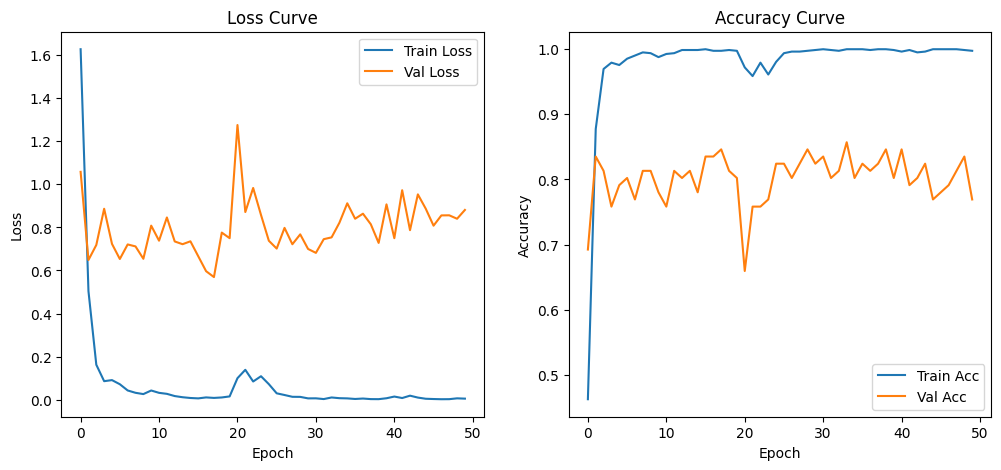

In [12]:
# ===============================================================
# 🔰 Plot Loss & Accuracy
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [13]:
# ===============================================================
# 🔰 Test evaluation
# ===============================================================
model.load_state_dict(torch.load("best_resnet50_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 86.14%
✅ Test time: 3.44 sec



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides     1.0000    1.0000    1.0000         8
Genus Helicotylenchus     0.9231    0.8571    0.8889        14
 Genus Hirschmaniella     0.7857    0.9167    0.8462        12
    Genus Hoplolaimus     0.8667    0.9286    0.8966        14
    Genus Meloidogyne     0.9200    0.8846    0.9020        26
   Genus Pratylenchus     0.6250    0.6250    0.6250         8
     Genus Radopholus     0.0000    0.0000    0.0000         1
    Genus Trichodorus     1.0000    0.8889    0.9412         9
      Genus Xiphinema     0.7000    0.7778    0.7368         9

             accuracy                         0.8614       101
            macro avg     0.7578    0.7643    0.7596       101
         weighted avg     0.8585    0.8614    0.8584       101



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


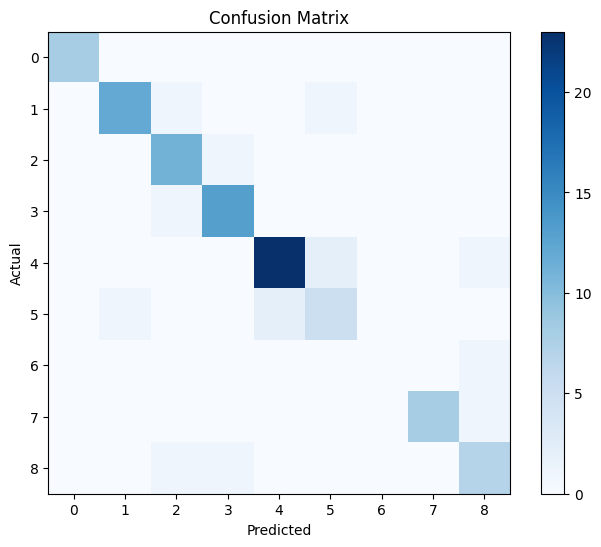


Per-class Accuracy:
Genus Criconemoides: 100.00%
Genus Helicotylenchus: 85.71%
Genus Hirschmaniella: 91.67%
Genus Hoplolaimus: 92.86%
Genus Meloidogyne: 88.46%
Genus Pratylenchus: 62.50%
Genus Radopholus: 0.00%
Genus Trichodorus: 88.89%
Genus Xiphinema: 77.78%


In [14]:

# ===============================================================
# 🔰 Classification report, Per-class accuracy & Confusion Matrix
# ===============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Model evaluation on test set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Only test set labels
unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

# ✅ Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

# ✅ Per-class accuracy (fixed)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


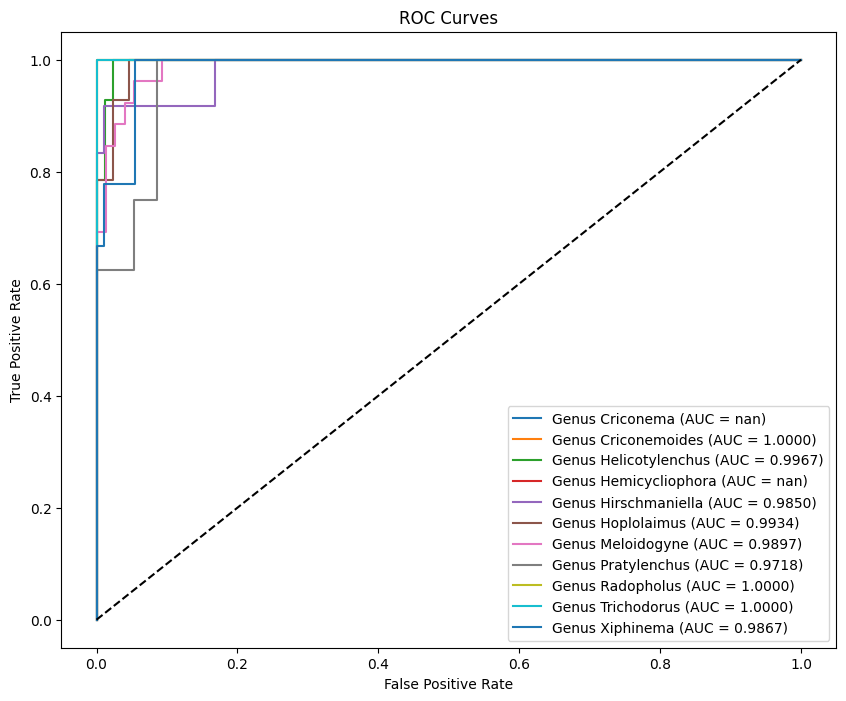

In [15]:
# ===============================================================
# 🔰 ROC-AUC per class (fixed)
# ===============================================================
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

plt.figure(figsize=(10,8))
for i, cls in enumerate(dataset.classes):
    # Convert to boolean array for current class
    y_true = (all_labels_np == i).astype(int)  # 0/1 labels
    y_score = all_probs_np[:, i]               # predicted probability for class i

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [16]:
# Model GFLOPs & Params calculation
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # ResNet-50 input
flops, params = profile(model, inputs=(dummy_input,))

print(f"\n✅ Model Complexity:")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} M")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

✅ Model Complexity:
FLOPs: 4.13 GFLOPs
Parameters: 23.53 M
